# Conditional GAN
---
*Responsible:* Robert Currie (<rob.currie@ed.ac.uk>)

## What is the target of this workshop?

### cGAN (paper - https://arxiv.org/abs/1411.1784)

The goal of this workshop is to construct and train a cGAN model from scratch using the mnist dataset.

This will be making use of the TensorFlow functional API to build a Generator and Discriminator model in separate and them combining these to train a complete cGAN model.

### FID (Fréchet Inception Distance)

Using the Inception v3 model from Google (paper - http://arxiv.org/abs/1512.00567) it's possible to calculate the FID metric from our trained model.

This gives us an ability to score the behaviour of our model compared to our real or training dataset.

$ FID = d^2 = \|\mu_1 - \mu_2\|^2 + Tr\left(\sigma_1 + \sigma_2 - 2\sqrt{ \sigma_1 \cdot \sigma_2 }\right) $


## Mark Schema

As with previous ML notebooks the sections marked **##FINISH ME##** are to be completed by you.

Marks for the different parts are shown below.

* Sections are intended to be tackled in order, i.e. 1->9
* In this notebook different sections can be tackled independently
* There are bonus problems at the end to tackle but the maximum mark is 10/10

| <p align='left'> Title                         | <p align='left'> Parts | <p align='left'> Number of marks |
| ------------------------------------- | ----- | --- |
| <p align='left'> 1. Load the dataset and normalise to $ \left[-1, 1\right] $ | <p align='left'>  1  | <p align='left'> 1 |
| <p align='left'> 2. Complete the Generator class | <p align='left'>  1  | <p align='left'> 1 |
| <p align='left'> 3. Use the Generator to generate some 'pseudo-numbers' with the correct shape | <p align='left'>  1  | <p align='left'> 1 |
| <p align='left'> 4. Complete the Discriminator class and use the Discriminator to decide if an image is real or fake | <p align='left'>  1  | <p align='left'> 1 |
| <p align='left'> 5. Complete the training methods for the cGAN class | <p align='left'>  1  | <p align='left'> 1 |
| <p align='left'> 6. Why are 2 separate optimizers needed for this cGAN model? | <p align='left'>  1  | <p align='left'> 1 |
| <p align='left'> 7. Write a method to generate&plot 10x10 images with numbers 0-9 left to right | <p align='left'>  1  | <p align='left'> 1 |
| <p align='left'> 8. Train the cGAN for 20 epochs | <p align='left'>  1  | <p align='left'> 1 |
| <p align='left'> 9. Complete the code required to calculate the FID | <p align='left'>  1  | <p align='left'> 1 |
| <p align='left'> 10. Calculate the FID for your trained model | <p align='left'>  1  | <p align='left'> 1 |
| <p align='left'> (Optional) 11. Plot how the FID for models varies vs training epochs | <p align='left'>  1  | <p align='left'> 1 |
| <p align='left'> **Total** | | <p align='left'> max **10** |



# First Imports and Fixing Reproducibility

TF on a GPU will use different algorithms behind the scenes then with a CPU.

Some of these algorithms will make some assumptions/sacrifices which will give up among other things exact numerical reproducibility in favour of speed/performance.

In addition to this, we should always try to fix the seeds for the AI/ML framework and NumPy

In [14]:
import os
import random
#os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
_FIXED_SEED=5432
os.environ["PYTHONHASHSEED"]=str(_FIXED_SEED)
random.seed(_FIXED_SEED)

import numpy as np
np.random.seed(_FIXED_SEED)

import tensorflow as tf
%pip install tqdm
from tqdm import tqdm
tf.random.set_seed(_FIXED_SEED)
tf.keras.utils.set_random_seed(_FIXED_SEED)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Importing the rest of the tools needed for the workshop

This workshop will focus on using the MNIST dataset again.

One of the reasons for this is that this datasdet has good ojects and features which means that we can recover the different species with relatively short training on a CPU.
If you have access to a GPU you can try running the same algorithms on more complex datasets to see the output. One of these is the fashion_mnist dataset.

In [15]:
# Used for building/training a cGAN
from numpy.random import randint
from matplotlib import pyplot
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import layers as L
from tensorflow.keras.losses import BinaryCrossentropy

#from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.datasets.mnist import load_data

# Used for calculating the FID of the model

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

# Global constants

In [16]:
# Target size
height_px, width_px, n_channels = (28, 28, 1)
BATCH_SIZE = 512
N_CLASSES = 10

SAVE_RESULT = "results"

LATENT_DIM = 100
DATASET_RANGE = (-1, 1)

# Set the number of epochs for trainining.
epochs = 20

# Load data

In [17]:
# Load train data
(x_train, y_train), (x_test, y_test) = load_data()

## Normalise the dataset to have values between $\left[-1, 1\right]$

We also want to build a TensorFlow dataset using `tf.data.Dataset.from_tensor_slices`

It's perhaps more of a convention that when traiing a GAN we normalise the dataset to be between [-1, 1] rather than [0,1]. This should have little impact in the final result other than changing your Generators final Activation layer.

In [18]:
def scale_dataset(dataset, scaled_min=-1, scaled_max=1,):
    # Find the current minimim and maximum value of dataset
    if isinstance(dataset, np.ndarray):
        current_min, current_max = dataset.min(), dataset.max()
    else:
        current_min, current_max = tf.reduce_min(dataset), tf.reduce_max(dataset)
    # Scale the data
    scaled_dataset = (scaled_max - scaled_min) * (dataset - current_min)/(current_max - current_min) + scaled_min
    
    # # Print check
    # print(f"Expected dataset scaling is [{int(scaled_min)}, {(scaled_max)}]")
    # print(f"Actual dataset scaling is [{int(scaled_dataset.min())}, {(scaled_dataset.max())}]\n")
    
    # Return a tensorflow tensor
    return scaled_dataset

x_train = scale_dataset(x_train)
x_test = scale_dataset(x_test)

# Create train and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train), )
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Define models

## Generator model

The GeneratorClass is where we want to collect everything together for the Generation of new pseudo-number images.

The intention is that we be able to call an instance of this class to generate a new value such as:

```
generator_instance = GeneratorClass(...)
output_image = generator_instance(noise=noise, label=label)
```

In [19]:
class GeneratorClass(tf.Module):
    def __init__(self, out_dim, n_classes=10, h_low=7, w_low=7):
        tf.Module.__init__(self)

        # 7x7 chosen to give us a 28x28 generated output
        n_nodes = h_low * w_low

        # Labels inputs
        # We need a sequential set of layers to take our label data and 'Embedding' this with a Dense output.
        # The output of this layer set has to output with the format of: h_low x w_low x 1

        self.label_embedding = tf.keras.Sequential([
            tf.keras.layers.Embedding(n_classes, output_dim=64),
            tf.keras.layers.Dense(n_nodes),
            tf.keras.layers.Reshape( (h_low, w_low, 1) )
        ])

        # Noise inputs
        # We need a sequential set of layers to go from the latent-space dim to be able to up-scale an image
        # The output of this layer set has to output with teh format of: h_low x w_low x 64

        self.noise_sampler = tf.keras.Sequential([
            tf.keras.layers.Dense(n_nodes*64),
            tf.keras.layers.Reshape( ( h_low, w_low, 64) )
        ])

        # Model layers
        # Building on the CNN model in the last workshop we need to build a sequential model to upscale using:
        # Conv2DTranspose 4x4 stride (2,2)
        # Conv2DTranspose 4x4 stride (2,2)
        # Conv2D 4x4 stride (1,1)
        # This model should take as input a 7x7 model and output a 28x28 

        self.upscale_model = tf.keras.Sequential([
            tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Conv2D(filters=out_dim, kernel_size=(4, 4), strides=(1, 1), padding="same"),
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.2),
        ])

        # merge layer for optim
        self.merge = L.Concatenate()

    @tf.function
    def __call__(self, labels, noise, training=False, reduce_retracing=True):

        # Take labels and add dense layer to connect them to noise images
        labels = self.label_embedding(labels, training=training)
        # Take noise 'seed' and to input images
        noise = self.noise_sampler(noise, training=training)

        # Merge the noise and labels
        x = self.merge([noise, labels])

        # Generate an output image from 'noise' seed using input label
        output_img = self.upscale_model(x, training=training)

        return output_img

## Now Construct a Generator instance and use it to 'generate' an image with a given label

We're going to use the g_model later, but we should check that it works as expected before we move on.

(-0.5, 27.5, 27.5, -0.5)

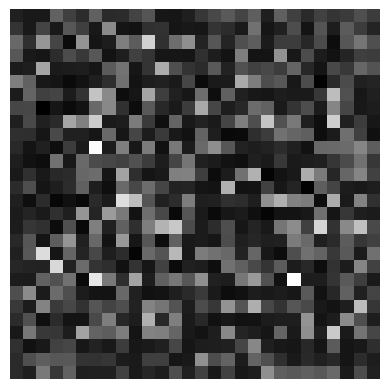

In [20]:
# Construct a Generator instance
g_model = GeneratorClass(n_channels, n_classes=N_CLASSES)
# This line is needed to help define our generator for later
call = g_model.__call__.get_concrete_function(tf.TensorSpec((1, 1), tf.int32, name='label'), tf.TensorSpec((1, LATENT_DIM), tf.float32, name='noise'))


## FINISH_ME ##
# Create test inputs
test_label = tf.constant([[2]] ,dtype=tf.float32)
test_data = tf.random.normal((1, LATENT_DIM), 0, 0.2, dtype=tf.float32)

# Check test input is within expected bounds
assert tf.reduce_min(test_data) > DATASET_RANGE[0] and tf.reduce_max(test_data) < DATASET_RANGE[1], "Randomly generated test_data is not within bounds [-1, 1]"

# Pass latent vector though generator
test_generated_image = g_model(test_label, test_data)

# Plot generated image
plt.imshow(tf.squeeze(test_generated_image, 0), cmap="gray", )
plt.axis("off")

## Discriminator model

This is our discriminator model which gives us an output of how 'real' or 'fake' an image as a single score between [0,1].

As with the generator we intend to be able to call an instance of this class to perform an evaluation on an input for us.

In [21]:
class DiscriminatorClass(tf.Module):
    def __init__(self, in_shape, out_dim, n_classes=10):
        tf.Module.__init__(self)

        n_nodes = in_shape[0]*in_shape[1]*in_shape[2]

        # Labels inputs
        # Build a short sequential model which embeds the the label data into a layer with the same dim as the input
        self.label_embedding = tf.keras.Sequential([
            tf.keras.layers.Embedding(n_classes, output_dim=64),
            tf.keras.layers.Dense(n_nodes),
            tf.keras.layers.Reshape((in_shape[0],in_shape[1],in_shape[2]))
        ])

        # Model layers 
        # Building on the CNN model in the last workshop we need to build a sequential model to downscale the input image into the latent-space
        self.downsample_model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=128, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(out_dim),
            tf.keras.layers.Activation("sigmoid"),
        ])

        # merge layer for optim
        self.merge = L.Concatenate()


    @tf.function
    def __call__(self, labels, images, training=False, reduce_retracing=True):
        
        # Take labels and add dense layer to connect them to noise images
        labels = self.label_embedding(labels, training=training)

        # Merge labels and images
        x = self.merge([images, labels])
        
        # Discriminate input and produce a vector representation of the input in latent-space
        latent_rep = self.downsample_model(x, training=training)

        return latent_rep

## Construct a Discriminator instance and use it to make a decision if an image is real ('1') or fake ('0')

We want to test the functionality again here, we haven't trained the model so don't expect the output to be correct.

In [22]:
d_model = DiscriminatorClass(in_shape=(height_px, width_px, n_channels), out_dim=1, n_classes=N_CLASSES)

## FINISH_ME ##
discriminator_logit = d_model(test_label, test_generated_image)
discriminator_prediction = tf.round(discriminator_logit)

print(discriminator_prediction.numpy())

[[1.]]


# Define whole cGAN class which controls the training process

The intention of the GAN model is that it captures everything to do with the training of the GAN within the train_step method.


In [23]:
class CGAN_Class(tf.Module):

    def __init__(self, discriminator, generator, latent_dim):
        tf.Module.__init__(self)
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        # Instantiate the optimizer for both networks
        # (learning_rate=0.0002, beta_1=0.5 are recommended)
        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
        self.bce = BinaryCrossentropy()


    def train_step(self, real_images, real_labels):

        # Get the batch size
        batch_size = tf.shape(real_images)[0]


        ## First train the Discriminator
        #################################

        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as tape:
            d_loss = self.discriminator_train_step(real_images, real_labels, random_latent_vectors)

        # Get the gradients w.r.t the discriminator loss
        d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update the weights of the discriminator using the discriminator optimizer
        self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))


        ## Now train the Generator
        #################################

        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_labels = tf.random.uniform([batch_size], minval=0, maxval=N_CLASSES, dtype=tf.int32)

        # Train the generator
        # Get the latent vector
        with tf.GradientTape() as tape:
            g_loss = self.generator_train_step(random_latent_vectors, random_labels)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))   

        
        ## Return the Discriminator and the Generator loss
        return {"d_loss": d_loss, "g_loss": g_loss}


    def discriminator_train_step(self, real_images, real_labels, random_latent_vectors):

        # Generate fake images from the latent vector
        fake_images = self.generator(labels=real_labels, noise=random_latent_vectors, training=False)
        # Get the logits for the fake images
        fake_logits = self.discriminator(labels=real_labels, images=fake_images, training=True)
        # Get the logits for the real images
        real_logits = self.discriminator(labels=real_labels, images=real_images, training=True)


        ## Calculate the BCE for the Real and Fake images
        ## Hint: `tf.ones_like` and `tf.zeros_like` gives us a Tensor with dimensions similar to input to use in BCE
        real_loss = self.bce( tf.ones_like(real_logits), real_logits )
        fake_loss = self.bce( tf.zeros_like(fake_logits), fake_logits)
        return (fake_loss + real_loss) * 0.5


    def generator_train_step(self, random_latent_vectors, random_labels):
        # Train the generator

        # Generate fake images using the generator
        generated_images = self.generator(labels=random_labels, noise=random_latent_vectors, training=True)
        # Get the discriminator logits for fake images
        gen_img_logits = self.discriminator(labels=random_labels, images=generated_images, training=False)

        ## Calculate the generator loss
        ## Hint: we're training the generator to 'trick' the Discriminator
        g_loss = self.bce( tf.ones_like(gen_img_logits), gen_img_logits )
        
        return g_loss



In [24]:
# Instantiate model.
cgan_model = CGAN_Class(discriminator=d_model, generator=g_model, latent_dim=LATENT_DIM,)

## Can you say why this cGAN model is using 2 separate optimizers for training?

When taking into account the goals of each model, the generator looks to reduce the Jensen-Shannon divergance between the probability distribution of the real dataset and the generated dataset. Meanwhile the Discriminator looks to do the opposit by increasing the Jensen-Shannon divergance. This results in both networks having the opposite goals.

If we were to use one optimiser for the same task of optimising both networks, we would run into an issue where the gradients computed during backpropogation to minimise one network (eg: Generator) would be the opposite gradients required to optimise the other network (eg: discirminator), resulting in the one network improving during training and the other network worsening doring training.

As a solutuion, we use two seperate optimisers which will compute the appropiate gradients for each network seperately (by running the backpropogation for each network indipendantly using their corresponding optimiser) and train both models concurrently.

# Build a method to generate and plot 10x10 images going 0-9, left-right

This method should take a model and use the Generator to generate 100 images with 10 zeros, ones, ... left to right in columns

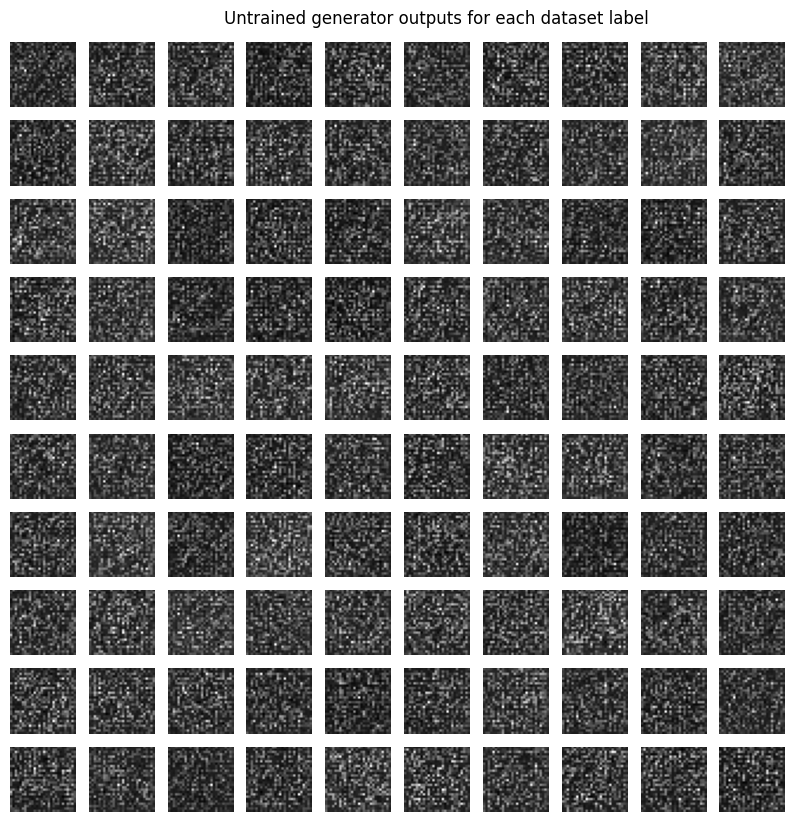

In [25]:
def generate_numbers(model, latent_dim):
    generate_latent_vector = lambda latent_dim : tf.random.normal(latent_dim, 0, 0.2)
    generated_images = {label: [] for label in range(10)}

    for label in generated_images:
        input_label = tf.constant([[label]], dtype=tf.float32)
        for _ in range(10):
            input_latent_vector = generate_latent_vector(latent_dim)
            generated_image = model(input_label, input_latent_vector)
            generated_images[label].append(tf.squeeze(generated_image, 0))
    
    return generated_images

def plot_numbers(model, latent_dim):
    generated_images = generate_numbers(model, latent_dim)
 
    fig, axes = plt.subplots(10, 10)
    fig.set_size_inches(10, 10)
    axes[0][5].set_title("Untrained generator outputs for each dataset label", y=1.15)
    for idx_row, row in enumerate(axes.T):
        for idx_column, column in enumerate(row):
            column.imshow(scale_dataset(generated_images[idx_row][idx_column], scaled_min=0, scaled_max=1), cmap="gray")
            column.axis("off")


plot_numbers(g_model, (1, LATENT_DIM))

# Run training

We now want to train our cGAN.

We want to report on the progress of our training every n steps and every epoch to make sure that the training is converging correctly.

Training the cGAN on CPLab machines should take ~1hr for 20 steps. You should expect to see number-like output from the model after 5-6 epochs and if you're stuck for time you can consider just training for 10 epochs.

#####	 Training has initiated 	#####


0it [00:00, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1706216760.888308   83942 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118it [00:15,  7.63it/s]


#####	 Epoch: 1/20 	##### G_loss = 1.0184704065322876 ##### D_loss = 0.7306452989578247


118it [00:11,  9.96it/s]


#####	 Epoch: 2/20 	##### G_loss = 0.8517401814460754 ##### D_loss = 0.5128077268600464


118it [00:11, 10.06it/s]


#####	 Epoch: 3/20 	##### G_loss = 0.6939451098442078 ##### D_loss = 0.6114501953125


118it [00:11, 10.04it/s]


#####	 Epoch: 4/20 	##### G_loss = 0.9723092913627625 ##### D_loss = 0.5787308216094971


118it [00:11, 10.11it/s]


#####	 Epoch: 5/20 	##### G_loss = 1.3004096746444702 ##### D_loss = 0.5215739607810974


118it [00:11, 10.16it/s]


#####	 Epoch: 6/20 	##### G_loss = 0.6186758875846863 ##### D_loss = 0.492378830909729


118it [00:11, 10.15it/s]


#####	 Epoch: 7/20 	##### G_loss = 1.1282590627670288 ##### D_loss = 0.39759889245033264


118it [00:11, 10.10it/s]


#####	 Epoch: 8/20 	##### G_loss = 1.631169319152832 ##### D_loss = 0.41184002161026


118it [00:11, 10.12it/s]


#####	 Epoch: 9/20 	##### G_loss = 1.6130456924438477 ##### D_loss = 0.359860897064209


118it [00:11, 10.14it/s]


#####	 Epoch: 10/20 	##### G_loss = 1.9463201761245728 ##### D_loss = 0.31194552779197693


118it [00:11, 10.35it/s]


#####	 Epoch: 11/20 	##### G_loss = 2.5386006832122803 ##### D_loss = 0.4021514654159546


118it [00:11, 10.19it/s]


#####	 Epoch: 12/20 	##### G_loss = 1.1105667352676392 ##### D_loss = 0.2879502773284912


118it [00:11, 10.16it/s]


#####	 Epoch: 13/20 	##### G_loss = 2.2886884212493896 ##### D_loss = 0.3468470275402069


118it [00:11, 10.14it/s]


#####	 Epoch: 14/20 	##### G_loss = 1.5668197870254517 ##### D_loss = 0.30031558871269226


118it [00:11, 10.18it/s]


#####	 Epoch: 15/20 	##### G_loss = 1.6859947443008423 ##### D_loss = 0.33810174465179443


118it [00:11, 10.24it/s]


#####	 Epoch: 16/20 	##### G_loss = 1.3185151815414429 ##### D_loss = 0.38350391387939453


118it [00:11, 10.17it/s]


#####	 Epoch: 17/20 	##### G_loss = 1.3439756631851196 ##### D_loss = 0.3999423086643219


118it [00:11, 10.16it/s]


#####	 Epoch: 18/20 	##### G_loss = 1.4480313062667847 ##### D_loss = 0.38657069206237793


118it [00:11, 10.17it/s]


#####	 Epoch: 19/20 	##### G_loss = 0.5915313363075256 ##### D_loss = 0.46221426129341125


118it [00:11, 10.19it/s]


#####	 Epoch: 20/20 	##### G_loss = 0.45431554317474365 ##### D_loss = 0.5352438688278198


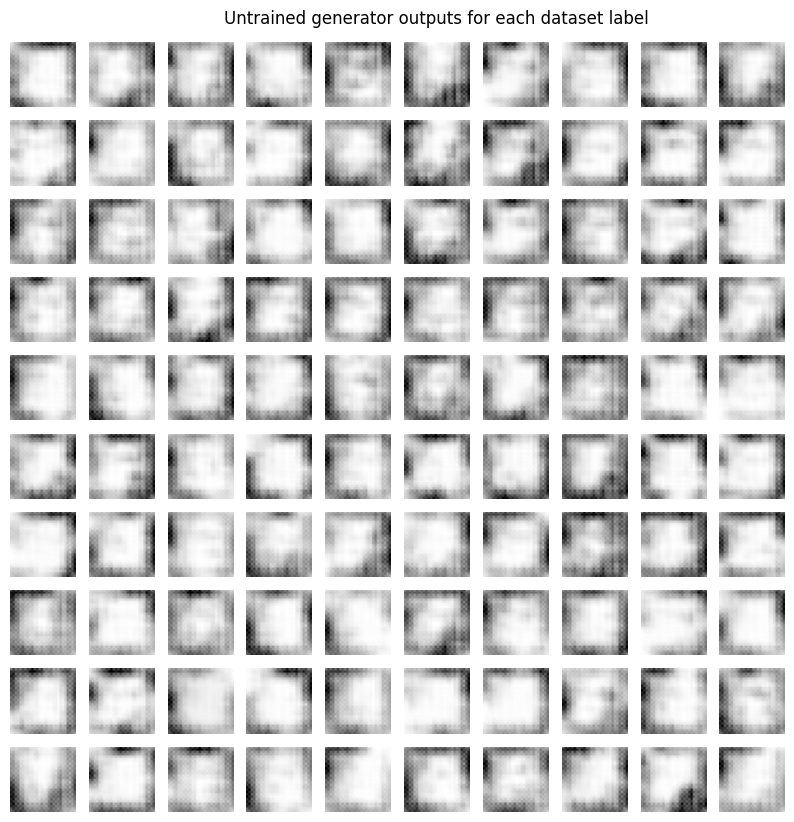

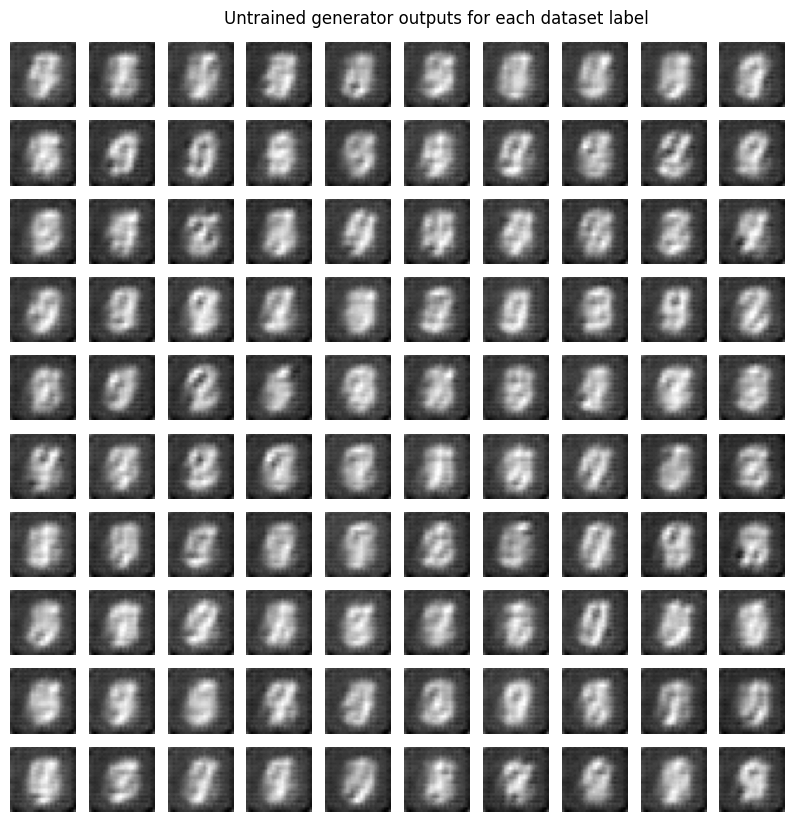

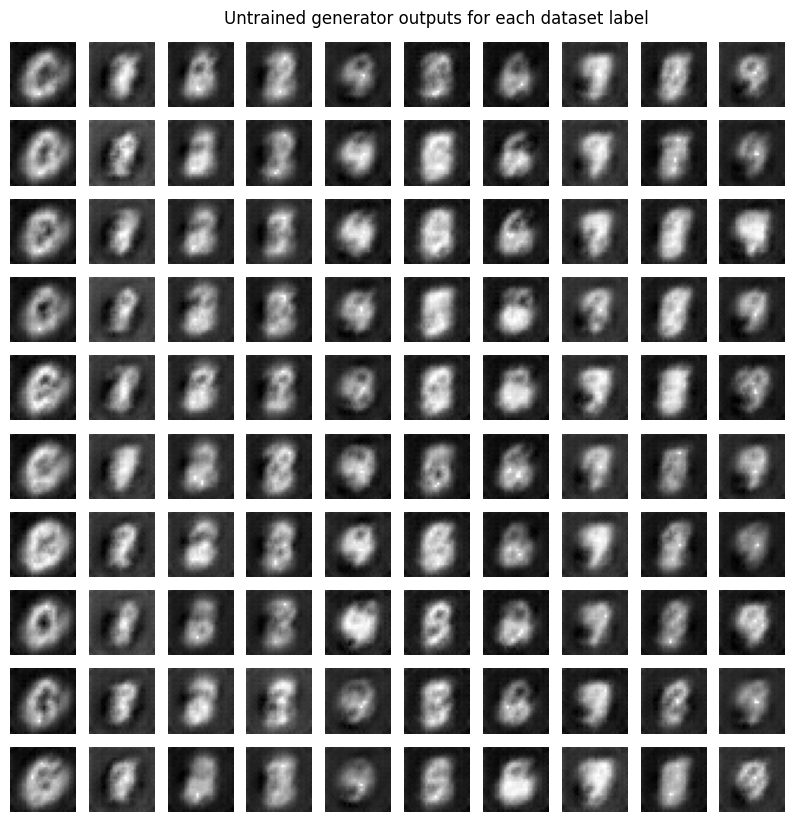

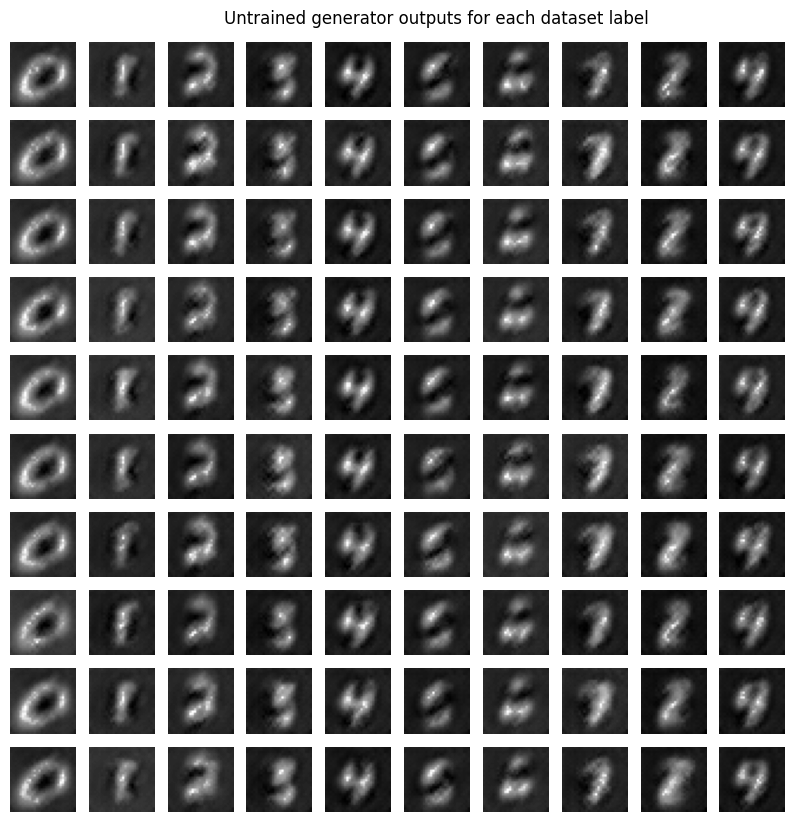

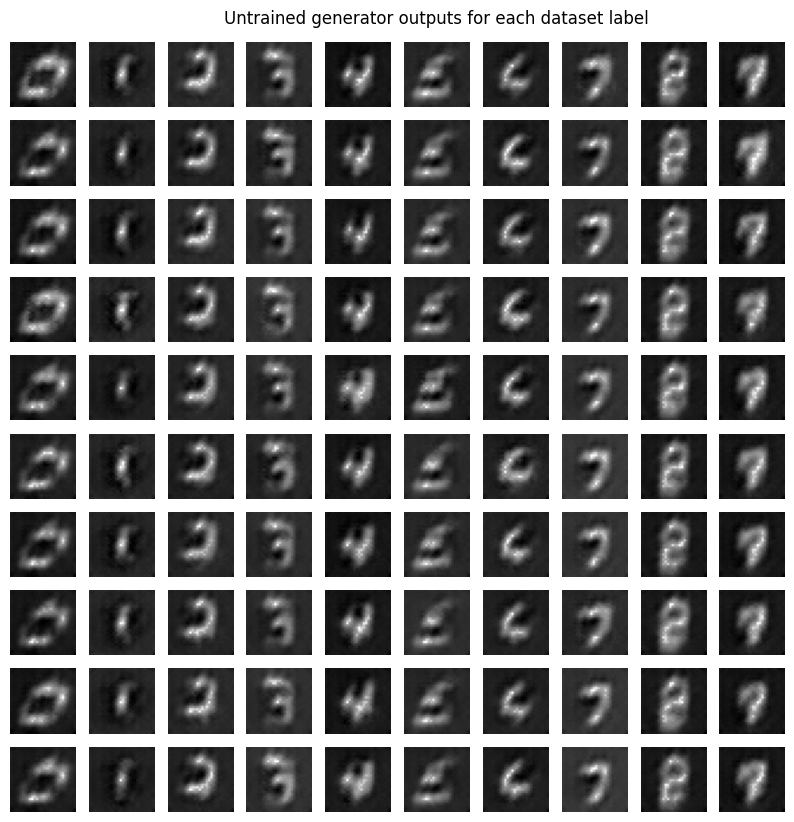

In [26]:
losses = {
    "d_loss": [],
    "g_loss": [],
}

print(f"{'#'*5}\t Training has initiated \t{'#'*5}")
for ep in range(epochs):
    # Shuffle and batch the dataset
    _dataset = train_dataset.shuffle(60000).batch(BATCH_SIZE)
    # Create an iterable over the dataset
    train_iter = iter(_dataset)
    for i, (real_images, real_labels) in tqdm(enumerate(train_iter)):
        real_images = tf.expand_dims(real_images, -1)
        real_labels = tf.expand_dims(real_labels, -1)
        data_losses = cgan_model.train_step(real_images=real_images, real_labels=real_labels)


        for key in data_losses:
            losses[key].append(data_losses[key])

        # Report on the progress of the training to make sure the training doesn't go wrong
        # At the start of each epoch, generate 10x10 new images and display them to see if the trained generator is improving
        # if i%5000==0:   
        #     print(f"Iteration: {i} {'#'*5} G_loss = {data_losses['g_loss']} {'#'*5} D_loss = {data_losses['d_loss']}")
    print(f"{'#'*5}\t Epoch: {ep+1}/{epochs} \t{'#'*5} G_loss = {data_losses['g_loss']} {'#'*5} D_loss = {data_losses['d_loss']}" )
    if ep in [0, 3, 6, 8, 10]:
        plot_numbers(cgan_model.generator, (1, LATENT_DIM))


In [37]:
def get_smoothed_values(data_list, decay=0.1):

    # This is technically an optional step, but plotting an averaged loss function is less intensive than throwing all of the raw values into pyplot
    decay_length = int(data_list.size * decay)
    data_list = data_list.reshape(decay_length, -1)
    final_values_list = np.average(data_list, axis=1)
    print(final_values_list.shape)
    
    return final_values_list

(472,)
(472,)


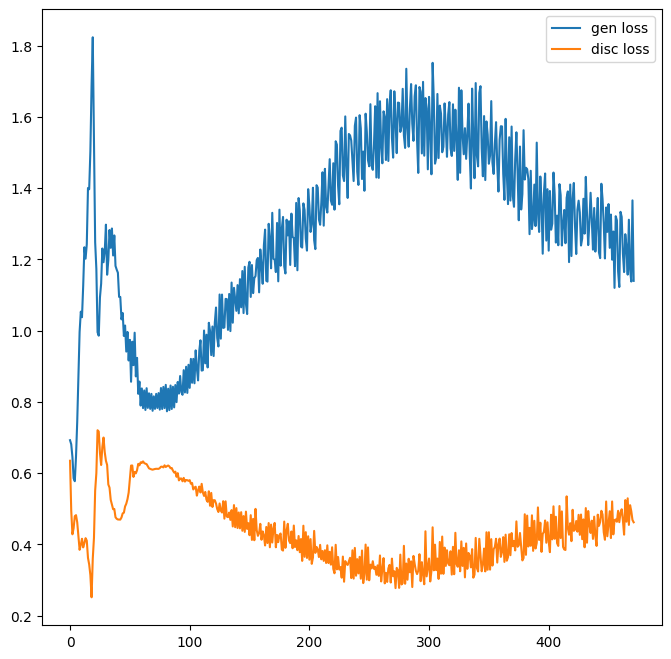

In [43]:
plt.figure(figsize=(8,8))
plt.plot(get_smoothed_values(np.array(losses["g_loss"]), decay=0.2))
plt.plot(get_smoothed_values(np.array(losses["d_loss"]), decay=0.2))
plt.xlabel("")
plt.legend(['gen loss', 'disc loss'])
plt.show()

# Save final model

In [ ]:
# Needed to allow us to save our model correctly and be able to call it after we load it from disk
call = g_model.__call__.get_concrete_function(tf.TensorSpec((1, 1), tf.int32, name='label'), tf.TensorSpec((1, LATENT_DIM), tf.float32, name='noise'))

In [ ]:
tf.saved_model.save(g_model, 'final_model_{}'.format(epochs), signatures=call)

### Zip model in order to download it

In [ ]:
!zip -r 'final_model.zip' 'final_model'

In order to download final model - click link below.

<h1><a href="final_model.zip"> Download trained generator </a></h1>

# Test saved model 

In [ ]:
model = tf.saved_model.load('final_model_{}'.format(epochs))

In [ ]:
random_latent_vectors = np.random.normal(size=(100, LATENT_DIM))
random_labels = np.asarray([min(x, N_CLASSES-1)  for _ in range(10) for x in range(10)])
#generated_images = model(label_i=random_labels, noise_i=random_latent_vectors)
generated_images = model(random_labels, random_latent_vectors)
# scale from [-1,1] to [0,1]
generated_images = ((generated_images + 1) / 2.0).numpy()

fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
indx = 0
for i, ax in enumerate(axes.flat):
    img = generated_images[i]#.reshape(height_px, width_px)
    ax.imshow(img, cmap='gray')
    label_leg = random_labels[i]
    ax.set_title(label_leg)
    
plt.show()

# Calculate FID metric

This is calculating the FID distance between 2 distributions as defined at the top of the notebook.

This uses the InceptionV3 model from Google to calculate 'activations' based on the presented images. We then effevctively want to compare the distribution of 'real' and 'fake' images in this activation-space.

If the Generator is perfectly the same as the training data this distance would be zero as the generator would be generating new numbers. Hence the smaller the distance between the 2 distributions of images the closer the generator generatig new instances from the input datadet. Large numbers here suggest the generator may be generating new datapoints which may not be realistic or physical.

In [ ]:
N_DATA = 60000
N_BATCH = 30

#x_test, y_test = shuffle(x_test, y_test)

generated_imgs_list = []
for label in y_test[:N_DATA]:

    ## GENERATE N_DATA 'pseudo-datapoints' from the same labels as the real _training_ data ##
    

In [ ]:
# Test plot
plt.imshow(generated_imgs_list[400][0], cmap='gray'), y_test[400]

In [ ]:
# Meet inception model minimum size and channels, 75x75x3
inception_model_input = (height_px*3, width_px*3, n_channels*3)

In [ ]:
# scale an array of images to a new size
def scale_images(images, new_shape=inception_model_input):
    images_list = list()

    ## FINISH_ME ##

    ## IMAGES FROM OUR GENERATOR NEED TO BE SCALED TO A SIZE WE CAN USE THEM WITH InceptionV3 ##
    ## HINT: tf.image.resize exists for such problems ##

    return np.asarray(images_list)

In [ ]:
def take_prediction(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    return act1, act2

In [ ]:
def collect_prediction(model, images1, images2, bs=N_BATCH):
    """
    Collect prediction on `images1`/`imges2` datasets with `model` 
    using batch size equal to `bs`
    """
    final_act1_l = []
    final_act2_l = []
    
    batch_i1 = []
    batch_i2 = []

    ## FINISH_ME ##

    ## We need to:
    ## 1) iterate through all of out input and generated data
    ## 2) Scale all images to the correct size so we can use this model
    ## 3) Convert the images from B&W to RGB using `tf.image.grayscale_to_rgb` or equivalent (again just for compatability with the model)
    ## 4) Calculate and store the predictions for the real and fake data


    final_act1_l = np.concatenate(final_act1_l, axis=0)
    final_act2_l = np.concatenate(final_act2_l, axis=0)
    return final_act1_l, final_act2_l

In [ ]:
# calculate frechet inception distance
def calculate_fid(model, images1, images2, bs=N_BATCH):

    # Calculate activations for real and fake data
    # The returned list/vector of activations should be the same length
    act1, act2 = collect_prediction(model, images1, images2, bs)

    # calculate mean and covariance-matrix over all analyzed images in 'activation-space'
    # You should have a 1D tensor of vectors in the activation-space in numpy
    # With that in mind you should be able to use the numpy built-in methods to extract the means and varience
    mu1, sigma1 = ## FINISH_ME ##
    mu2, sigma2 = ## FINISH_ME ##

    # difference between means ^2
    mu_diff = np.sum((mu1 - mu2)**2.0)
    # SQRT of dot-product of sigmas
    covmean = sqrtm(sigma1.dot(sigma2))
    # Only take real values
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # calculate distance
    fid = mu_diff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

In [ ]:
# Prepare the inception v3 model
classifier_model = InceptionV3(include_top=False, pooling='avg', input_shape=inception_model_input)
# Take parts of datasets
images1 = generated_imgs_list[:N_DATA]
images2 = x_test[:N_DATA]

In [ ]:
# Calculate fid between images1 and images2
fid = calculate_fid(classifier_model, images1, images2, BATCH_SIZE)

In [ ]:
print('FID (different): %.3f' % fid)

## Show how FID changes as models improve

I've provided a few examples of the cGAN model which have been trained by a GPU.

As a short 'free-form' exercise, load each of these models and use them to calculate how the FID varies for a more trained model.